# **Neuropolis: Building an artificial intelligence system for human brain activity prediction (EEG, fMRI)**

#### Version: 10th March 2024

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

==============================================================================================

This project is presented through nine Notebooks:

*01: fMRI Preprocessing*

*02: EEG Preprocessing*

*03: Linear Regression*

*04: KNN, Decision Trees, Random Forests, SVM*

*05: Neural Networks*

*06: Convolutional Neural Networks*

*07: Recurrent Neural Networks*

*08: Transformers*

***09: Human Brain Predictability Map***

==============================================================================================

### Notebook 09

# **Human Brain Predictability Map**

## **1. Brain Map**

- **Targets**: We compute the group mask, then apply this mask, as well as a voxel size rescaling by a factor 3, to all fMRI images. After the rescaling, each new voxel corresponds to the mean value of a 27-voxel cluster. We compute a regression line representing the average increase of the BOLD signal inside the brain, and remove this effect from each target. Then, we normalize the targets, and replace the outliers (STD > 3) by the value of the previous scan. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
import pickle
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# Define the fmriprep data path. 
fmriprep_data_path = '../neuropolis_fmriprep_data/'

# Define the preprocessed data path. 
preprocessed_data_path = '../neuropolis_preprocessed_data/'

In [3]:
# Load the features. 
with open(preprocessed_data_path + 'features/dict_features_basis.p', 'rb') as file:
    dict_features_basis = pickle.load(file)
with open(preprocessed_data_path + 'features/dict_features_sequence.p', 'rb') as file:
    dict_features_sequence = pickle.load(file)

In [4]:
# Define the list of subjects, removing sub-xp102 who has a missing condition. 
subjects = ['sub-xp1' + str(x).zfill(2) for x in range(1, 11)]
subjects.remove('sub-xp102')
subject = subjects[0]

# Retrieve the total number of scans. 
nb_scans_total = dict_features_basis[subject]['eegfmriNF'].shape[0]

In [5]:
# Define a function to return the middle sections of an image data array. 
def middle_sections(image_data):
    return tuple((np.array(image_data[:, :, :].shape) / 2).astype(int))

In [6]:
# Define a function to display sections of an image through the sagittal, coronal, and axial views, using the middle sections coordinates. 
def display_fMRI_image(image_data, middle_coord, scan = 0):
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 5))

    # If the image_data array contains several scans, select the scan given as argument. 
    if len(image_data.shape) == 4:
        image_data = image_data[:, :, :, scan]

    axes[0].imshow(image_data[middle_coord[0], :, :].T, origin = 'lower')
    axes[0].set_title('Sagittal view')
    axes[1].imshow(image_data[:, middle_coord[1], :].T, origin = 'lower')
    axes[1].set_title('Coronal view')
    axes[2].imshow(image_data[:, :, middle_coord[2]], origin = 'lower')
    axes[2].set_title('Axial view');

In [7]:
# Load an example mask using the NiBabel library, and define a group mask based on its shape. 
mask_img = nib.load(fmriprep_data_path + subject + '/func/' +  subject + '_task-eegfmriNF_space-MNI152Lin_desc-brain_mask.nii.gz')
group_mask = np.ones(mask_img.shape)
df_summary = pd.DataFrame()

# Iterate through all subjects. 
for subject in subjects:

    # Load the subject mask using the NiBabel library, and extract the image data. 
    mask_img = nib.load(fmriprep_data_path + subject + '/func/' +  subject + '_task-eegfmriNF_space-MNI152Lin_desc-brain_mask.nii.gz')
    mask_data = mask_img.get_fdata()
    df_summary.loc[subject, 'Shape of the mask'] = str(mask_data.shape)
    df_summary.loc[subject, 'Proportion of voxels in the mask'] = np.sum(mask_data == 1) / np.prod(mask_data.shape)

    # Add the subject mask to the group mask. 
    group_mask = group_mask * mask_data

df_summary.loc['Group mask', 'Shape of the mask'] = str(group_mask.shape)
df_summary.loc['Group mask', 'Proportion of voxels in the mask'] = np.sum(group_mask == 1) / np.prod(group_mask.shape)

In [8]:
# Display the summary DataFrame. 
df_summary

,Shape of the mask,Proportion of voxels in the mask
sub-xp101,"(76, 95, 40)",0.435699
sub-xp103,"(76, 95, 40)",0.430509
sub-xp104,"(76, 95, 40)",0.427711
sub-xp105,"(76, 95, 40)",0.430291
sub-xp106,"(76, 95, 40)",0.433982
sub-xp107,"(76, 95, 40)",0.419952
sub-xp108,"(76, 95, 40)",0.456859
sub-xp109,"(76, 95, 40)",0.425100
sub-xp110,"(76, 95, 40)",0.426080
Group mask,"(76, 95, 40)",0.376742


In [9]:
# Find the middle sections coordinates of the group mask data array. 
middle_coord = middle_sections(group_mask[:, :, :])
middle_coord

(38, 47, 20)

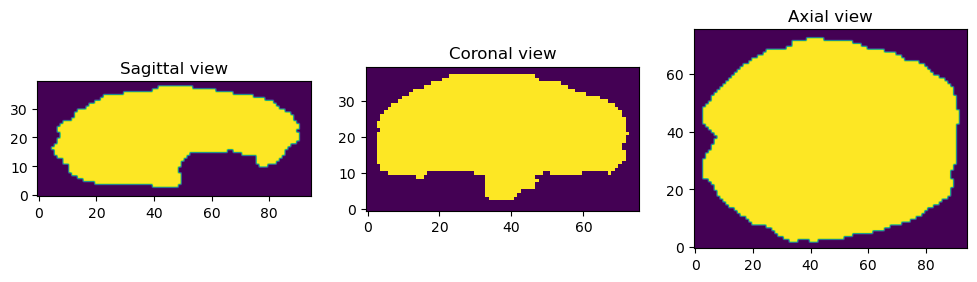

In [10]:
# Display sections of the group mask through the sagittal, coronal, and axial views, using the middle sections coordinates. 
display_fMRI_image(group_mask, middle_coord)

In [11]:
# Convert to Boolean. 
binary_mask_3d = group_mask.astype(bool)

# Convert the 3D binary mask into a 4D binary mask, by repeating the Boolean values along a 4th dimension. 
binary_mask_4d = np.repeat(binary_mask_3d[:, :, :, np.newaxis], nb_scans_total, axis = 3)
binary_mask_4d.shape

(76, 95, 40, 200)

In [12]:
# Define the dictionaries and the summary DataFrame. 
dict_targets_values_masked = dict()
dict_mean_values_inside_brain = dict()
df_summary = pd.DataFrame()

# Iterate through all subjects. 
for subject in subjects:

    # Display current subject. 
    print(subject)

    # Define the subject dictionaries. 
    dict_targets_values_masked[subject] = dict()
    dict_mean_values_inside_brain[subject] = dict()

    # Iterate through all conditions. 
    for condition in ['eegNF', 'fmriNF', 'eegfmriNF']:

        # Load the image and extract the image data. 
        img = nib.load(fmriprep_data_path + subject + '/func/' + subject + '_task-' + condition + '_space-MNI152Lin_desc-preproc_bold.nii.gz')
        image_data = img.get_fdata()

        # Apply the mask. 
        image_data_inside_brain = image_data[:, :, :, :nb_scans_total].copy()
        image_data_inside_brain[~binary_mask_4d] = np.nan

        # Store the masked image, the mean image values, and the masked image shape. 
        dict_targets_values_masked[subject][condition] = image_data_inside_brain
        dict_mean_values_inside_brain[subject][condition] = np.nanmean(image_data_inside_brain, axis = (0, 1, 2))
        df_summary.loc[subject, condition] = str(image_data_inside_brain.shape)

sub-xp101
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [13]:
# Display the summary DataFrame. 
print('Masked images shapes')
df_summary

Masked images shapes


,eegNF,fmriNF,eegfmriNF
sub-xp101,"(76, 95, 40, 200)","(76, 95, 40, 200)","(76, 95, 40, 200)"
sub-xp103,"(76, 95, 40, 200)","(76, 95, 40, 200)","(76, 95, 40, 200)"
sub-xp104,"(76, 95, 40, 200)","(76, 95, 40, 200)","(76, 95, 40, 200)"
sub-xp105,"(76, 95, 40, 200)","(76, 95, 40, 200)","(76, 95, 40, 200)"
sub-xp106,"(76, 95, 40, 200)","(76, 95, 40, 200)","(76, 95, 40, 200)"
sub-xp107,"(76, 95, 40, 200)","(76, 95, 40, 200)","(76, 95, 40, 200)"
sub-xp108,"(76, 95, 40, 200)","(76, 95, 40, 200)","(76, 95, 40, 200)"
sub-xp109,"(76, 95, 40, 200)","(76, 95, 40, 200)","(76, 95, 40, 200)"
sub-xp110,"(76, 95, 40, 200)","(76, 95, 40, 200)","(76, 95, 40, 200)"


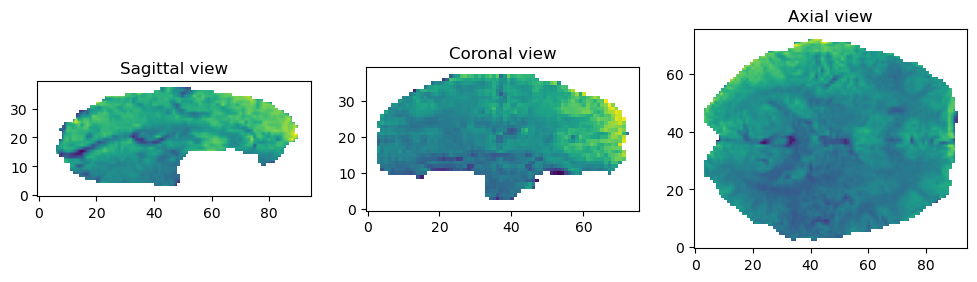

In [14]:
# Display sections of a masked image through the sagittal, coronal, and axial views, using the middle sections coordinates. 
subject = subjects[0]
display_fMRI_image(dict_targets_values_masked[subject]['eegfmriNF'], middle_coord)

In [15]:
# Define the rescaling function. 
def rescale_image_by_factor(image_data, factor):
    
    # Get the dimensions of the image data, and create a new, rescaled, image data array. 
    dimensions = np.append((np.array(image_data.shape[0:3]) / factor).astype('int'), image_data.shape[3])
    new_image_data = np.zeros((dimensions))
    
    # Iterate through all voxels in the new image data. 
    for x_coord in range(0, dimensions[0]):
        for y_coord in range(0, dimensions[1]):
            for z_coord in range(0, dimensions[2]):
                new_image_data[x_coord, y_coord, z_coord, :] = np.mean(image_data[(factor * x_coord):(factor * x_coord + factor),
                                                                                  (factor * y_coord):(factor * y_coord + factor),
                                                                                  (factor * z_coord):(factor * z_coord + factor),
                                                                                  :], axis = (0, 1, 2))
                
    # Return the new image data. 
    return new_image_data

In [16]:
# Define the dictionary and the summary DataFrame. 
dict_targets_values_rescaled = dict()
df_summary = pd.DataFrame()

# Iterate through all subjects. 
for subject in subjects:

    # Display current subject. 
    print(subject)

    # Define the subject dictionary. 
    dict_targets_values_rescaled[subject] = dict()

    # Iterate through all conditions. 
    for condition in ['eegNF', 'fmriNF', 'eegfmriNF']:

        # Load the masked image. 
        image_data_masked = dict_targets_values_masked[subject][condition]

        # Rescale the voxel size by a factor 3. 
        image_data_rescaled = rescale_image_by_factor(image_data_masked, 3)

        # Store the rescaled image and its shape. 
        dict_targets_values_rescaled[subject][condition] = image_data_rescaled
        df_summary.loc[subject, condition] = str(image_data_rescaled.shape)

sub-xp101
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [17]:
# Display the summary DataFrame. 
print('Rescaled images shapes')
df_summary

Rescaled images shapes


,eegNF,fmriNF,eegfmriNF
sub-xp101,"(25, 31, 13, 200)","(25, 31, 13, 200)","(25, 31, 13, 200)"
sub-xp103,"(25, 31, 13, 200)","(25, 31, 13, 200)","(25, 31, 13, 200)"
sub-xp104,"(25, 31, 13, 200)","(25, 31, 13, 200)","(25, 31, 13, 200)"
sub-xp105,"(25, 31, 13, 200)","(25, 31, 13, 200)","(25, 31, 13, 200)"
sub-xp106,"(25, 31, 13, 200)","(25, 31, 13, 200)","(25, 31, 13, 200)"
sub-xp107,"(25, 31, 13, 200)","(25, 31, 13, 200)","(25, 31, 13, 200)"
sub-xp108,"(25, 31, 13, 200)","(25, 31, 13, 200)","(25, 31, 13, 200)"
sub-xp109,"(25, 31, 13, 200)","(25, 31, 13, 200)","(25, 31, 13, 200)"
sub-xp110,"(25, 31, 13, 200)","(25, 31, 13, 200)","(25, 31, 13, 200)"


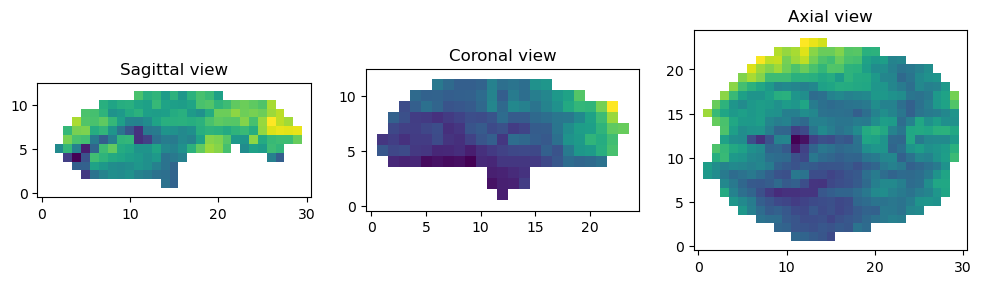

In [18]:
# Display sections of a rescaled image through the sagittal, coronal, and axial views, using the middle sections coordinates. 
subject = subjects[0]
image_data_masked = dict_targets_values_masked[subject]['eegfmriNF']
image_data_rescaled = dict_targets_values_rescaled[subject]['eegfmriNF']
middle_coord_rescaled = middle_sections(image_data_rescaled)
display_fMRI_image(dict_targets_values_rescaled[subject]['eegfmriNF'], middle_coord_rescaled)

In [19]:
# Display the memory usage. 
print('Original image:', str(image_data_masked.nbytes), 'bytes')
print('Rescaled image:', str(image_data_rescaled.nbytes), 'bytes')
print('The original image is', str(np.round(image_data.nbytes / image_data_rescaled.nbytes, 2)), 'times heavier than the rescaled image.')

Original image: 462080000 bytes
Rescaled image: 16120000 bytes
The original image is 30.1 times heavier than the rescaled image.


In [20]:
# Define the dictionaries and the outliers DataFrame. 
dict_targets_values = dict()
dict_voxel_indexes = dict()
df_outliers = pd.DataFrame()

# Iterate through all subjects. 
for subject in subjects:

    # Display current subject. 
    print(subject)

    # Define the subject dictionaries. 
    dict_targets_values[subject] = dict()
    dict_voxel_indexes[subject] = dict()

    # Iterate through all conditions. 
    for condition in ['eegNF', 'fmriNF', 'eegfmriNF']:

        # Load the rescaled image. 
        image_data_rescaled = dict_targets_values_rescaled[subject][condition]

        # Compute the regression coefficients. 
        mean_values_inside_brain = dict_mean_values_inside_brain[subject][condition]
        x_values = range(nb_scans_total)
        coefficients = np.polyfit(x_values, mean_values_inside_brain, 1)

        # Compute the corrected image data value. 
        y_values = coefficients[0] * x_values + coefficients[1]
        image_data_corrected = image_data_rescaled - y_values

        # Retrieve the indexes and total number of non-NaN voxels per scan. 
        voxel_indexes = ~np.isnan(image_data_corrected[:, :, :, 0])
        nb_voxel_indexes = np.sum(voxel_indexes)

        # Create NumPy arrays with one row per scan and one column per non-NaN voxel. 
        image_data_flattened = np.empty((nb_scans_total, nb_voxel_indexes))
        image_data_normalized = image_data_flattened.copy()

        # Iterate through all scans and flatten the data. 
        for scan in range(nb_scans_total):
            flattened_image = image_data_corrected[:, :, :, scan].flatten()
            flattened_image = flattened_image[~np.isnan(flattened_image)]
            image_data_flattened[scan, :] = flattened_image
        
        # Iterate through all voxels. 
        outliers_counter = 0
        for voxel in range(nb_voxel_indexes):

            # Compute the normalized voxel values. 
            image_data_normalized[:, voxel] = (image_data_flattened[:, voxel] - np.mean(image_data_flattened[:, voxel])) / np.std(image_data_flattened[:, voxel])

            # Iterate through all scans and replace the outliers (STD > 3) by the value of the previous scan. 
            for scan in range(nb_scans_total):
                if np.abs(image_data_normalized[scan, voxel]) > 3:
                    image_data_normalized[scan, voxel] = image_data_normalized[scan - 1, voxel]
                    outliers_counter += 1

        # Fill in the dictionaries and outliers DataFrame. 
        dict_targets_values[subject][condition] = image_data_normalized
        dict_voxel_indexes[subject][condition] = voxel_indexes
        df_outliers.loc[subject, condition] = outliers_counter / (image_data_flattened.shape[1] * nb_scans_total)

sub-xp101
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [21]:
# Display the proportion of outliers. 
df_outliers

,eegNF,fmriNF,eegfmriNF
sub-xp101,0.011086,0.008841,0.006105
sub-xp103,0.002913,0.001433,0.002153
sub-xp104,0.007395,0.004026,0.004083
sub-xp105,0.002903,0.001864,0.002125
sub-xp106,0.002671,0.003535,0.002604
sub-xp107,0.002276,0.001836,0.002293
sub-xp108,0.001681,0.001736,0.001640
sub-xp109,0.001433,0.001379,0.001682
sub-xp110,0.002366,0.001967,0.001893


## **2. Predictability Map**

- **Models**: We train a linear regression model, and three K-Nearest Neighbors (KNN) models with respectively 5, 20, and 50 neighbors. Our objective is to maximize the R^2 metrics. 

- **Strategy**: We limit ourselves to the Predictor Brains strategy, i.e., we use the eegfmriNF condition as the train set, and the eegNF and fmriNF conditions as the test set, individually for each subject. 

- **Results**: For the KNN models with 20 and 50 neighbors, some voxels show a positive R^2 metrics. 

In [22]:
# Define the Mean Squared Error function. 
def MSE(y, y_pred):
    return np.mean(np.square(y - y_pred))

In [23]:
# Define the Mean Absolute Error function. 
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [24]:
# Define the Residual Sum of Squares function. 
def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))

In [25]:
# Define a function to run a regression model for the Predictor Brains strategy. 
def run_regression_model_predictor_brains(RegressionModel, dict_features_sequence, dict_targets_values, sequence_length):

    # Define the dictionaries and the summary DataFrame. 
    dict_models = dict()
    dict_baseline = dict()
    dict_predictions = dict()
    df_summary = pd.DataFrame()

    # TRAINING LOOP. Iterate through all subjects. 
    for subject in subjects:

        # Display current subject. 
        print(subject)

        # Clone the Scikit-Learn estimator. 
        PredictorBrain = clone(RegressionModel)

        # Retrieve the features and targets of the train set. 
        X_tr = dict_features_sequence[subject]['eegfmriNF']
        Y_tr = dict_targets_values[subject]['eegfmriNF'][sequence_length:, :]

        # Train the model. 
        PredictorBrain.fit(X_tr, Y_tr)

        # Store the trained model and the baseline in the dictionaries. 
        dict_models[subject] = PredictorBrain
        dict_baseline[subject] = np.ones(Y_tr.shape) * Y_tr.mean()

    # PREDICTION LOOP. Iterate through all subjects. 
    for subject in subjects:

        # Define the subject dictionary. 
        dict_predictions[subject] = dict()

        # Iterate through all conditions. 
        for condition in ['eegNF', 'fmriNF']:

            # Retrieve the features and targets of the test set, the baseline, and the trained model. 
            X_te = dict_features_sequence[subject][condition]
            Y_te = dict_targets_values[subject][condition][sequence_length:, :]
            Baseline = dict_baseline[subject]
            PredictorBrain = dict_models[subject]

            # Predict the target values. 
            Y_pred = PredictorBrain.predict(X_te)

            # Evaluate the performance metrics. 
            mse_baseline = MSE(Y_te, Baseline)
            mae_baseline = MAE(Y_te, Baseline)
            rss_baseline = RSS(Y_te, Baseline)
            mse_model = MSE(Y_te, Y_pred)
            mae_model = MAE(Y_te, Y_pred)
            rss_model = RSS(Y_te, Y_pred)
            r2_model = 1 - (rss_model / rss_baseline)

            # Store the performance metrics and the shapes of the arrays in the DataFrame. 
            df_summary.loc[subject + '/' + condition, 'subject'] = subject
            df_summary.loc[subject + '/' + condition, 'condition'] = condition
            df_summary.loc[subject + '/' + condition, 'mse_baseline'] = mse_baseline
            df_summary.loc[subject + '/' + condition, 'mae_baseline'] = mae_baseline
            df_summary.loc[subject + '/' + condition, 'rss_baseline'] = rss_baseline
            df_summary.loc[subject + '/' + condition, 'mse_model'] = mse_model
            df_summary.loc[subject + '/' + condition, 'mae_model'] = mae_model
            df_summary.loc[subject + '/' + condition, 'rss_model'] = rss_model
            df_summary.loc[subject + '/' + condition, 'r2_model'] = r2_model
            df_summary.loc[subject + '/' + condition, 'X_tr.shape'] = str(X_tr.shape)
            df_summary.loc[subject + '/' + condition, 'X_te.shape'] = str(X_te.shape)
            df_summary.loc[subject + '/' + condition, 'Y_tr.shape'] = str(Y_tr.shape)
            df_summary.loc[subject + '/' + condition, 'Y_te.shape'] = str(Y_te.shape)

            # Store the predictions in the dictionary. 
            dict_predictions[subject][condition] = Y_pred

    # Change the indexes of the DataFrame. 
    df_summary = df_summary.set_index(['subject', 'condition'])
    
    return dict_predictions, dict_baseline, df_summary

In [26]:
# Define a function to build the predictability map. 
def build_predictability_map(dict_targets_values, dict_predictions, dict_baseline, sequence_length):

    # Define the NumPy array. 
    predictability_map = np.zeros(nb_voxel_indexes)

    # Iterate through all voxels. 
    for voxel in range(nb_voxel_indexes):

        # Define the baseline RSS and model RSS for this voxel. 
        rss_baseline_voxel = 0
        rss_model_voxel = 0

        # Iterate through all subjects. 
        for subject in subjects:

            # Iterate through all conditions. 
            for condition in ['eegNF', 'fmriNF']:

                # Retrieve the target, the predictions, and the baseline. 
                y_te = dict_targets_values[subject][condition][sequence_length:, :][:, voxel]
                y_pred = dict_predictions[subject][condition][:, voxel]
                Baseline = dict_baseline[subject][:, voxel]

                # Evaluate the performance metrics. 
                rss_baseline = RSS(y_te, Baseline)
                rss_model = RSS(y_te, y_pred)

                # Add the metrics to the baseline RSS and model RSS for this voxel. 
                rss_baseline_voxel = rss_baseline_voxel + rss_baseline
                rss_model_voxel = rss_model_voxel + rss_model

        # Compute and store the R^2 metrics for this voxel. 
        r2_model_voxel = 1 - (rss_model_voxel / rss_baseline_voxel)
        predictability_map[voxel] = r2_model_voxel

    return predictability_map

In [27]:
# Define a function for building a brain predictability map, mapping the R^2 metrics to a 3D brain image. 
def build_brain_predictability_map(voxel_indexes, predictability_map):
    
    # Create a NumPy array with the appropriate shape. 
    brain_predictability_map = np.zeros(voxel_indexes.shape)
    brain_predictability_map[:] = np.nan

    # Fill in this array with the coefficients, at the indexes corresponding to non-NaN values. 
    brain_predictability_map[voxel_indexes] = predictability_map
    
    return brain_predictability_map

In [28]:
# Define a function to display sections of a brain predictability map through the sagittal, coronal, and axial views, using the middle sections coordinates. 
def display_brain_predictability_map(image_data, middle_coord, colormap = 'Blues'):
    
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 5))
    fig.suptitle('Human Brain Predictability Map', fontsize = 14, y = 0.8)

    axes[0].imshow(image_data[middle_coord[0], :, :].T, origin = 'lower', cmap = colormap)
    axes[0].set_title('Sagittal view')
    axes[1].imshow(image_data[:, middle_coord[1], :].T, origin = 'lower', cmap = colormap)
    axes[1].set_title('Coronal view')
    axes[2].imshow(image_data[:, :, middle_coord[2]], origin = 'lower', cmap = colormap)
    axes[2].set_title('Axial view');

In [29]:
# Select a sequence length. 
selected_sequence_length = 5

In [30]:
# Run the linear regression model. 
dict_predictions_lr_pb, dict_baseline_lr_pb, df_summary_lr_pb = run_regression_model_predictor_brains(LinearRegression(n_jobs = -1),
                                                                                                      dict_features_sequence, 
                                                                                                      dict_targets_values, 
                                                                                                      selected_sequence_length)

sub-xp101
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [31]:
# Run the KNN model with 5 neighbors. 
dict_predictions_knn5_pb, dict_baseline_knn5_pb, df_summary_knn5_pb = run_regression_model_predictor_brains(KNeighborsRegressor(n_neighbors = 5, n_jobs = -1),
                                                                                                            dict_features_sequence, 
                                                                                                            dict_targets_values, 
                                                                                                            selected_sequence_length)

sub-xp101
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [32]:
# Run the KNN model with 20 neighbors. 
dict_predictions_knn20_pb, dict_baseline_knn20_pb, df_summary_knn20_pb = run_regression_model_predictor_brains(KNeighborsRegressor(n_neighbors = 20, n_jobs = -1),
                                                                                                               dict_features_sequence, 
                                                                                                               dict_targets_values, 
                                                                                                               selected_sequence_length)

sub-xp101
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [33]:
# Run the KNN model with 50 neighbors. 
dict_predictions_knn50_pb, dict_baseline_knn50_pb, df_summary_knn50_pb = run_regression_model_predictor_brains(KNeighborsRegressor(n_neighbors = 50, n_jobs = -1),
                                                                                                               dict_features_sequence, 
                                                                                                               dict_targets_values, 
                                                                                                               selected_sequence_length)

sub-xp101
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [34]:
# Build the predictability maps. 
predictability_map_lr_pb = build_predictability_map(dict_targets_values, dict_predictions_lr_pb, dict_baseline_lr_pb, selected_sequence_length)
predictability_map_knn5_pb = build_predictability_map(dict_targets_values, dict_predictions_knn5_pb, dict_baseline_knn5_pb, selected_sequence_length)
predictability_map_knn20_pb = build_predictability_map(dict_targets_values, dict_predictions_knn20_pb, dict_baseline_knn20_pb, selected_sequence_length)
predictability_map_knn50_pb = build_predictability_map(dict_targets_values, dict_predictions_knn50_pb, dict_baseline_knn50_pb, selected_sequence_length)

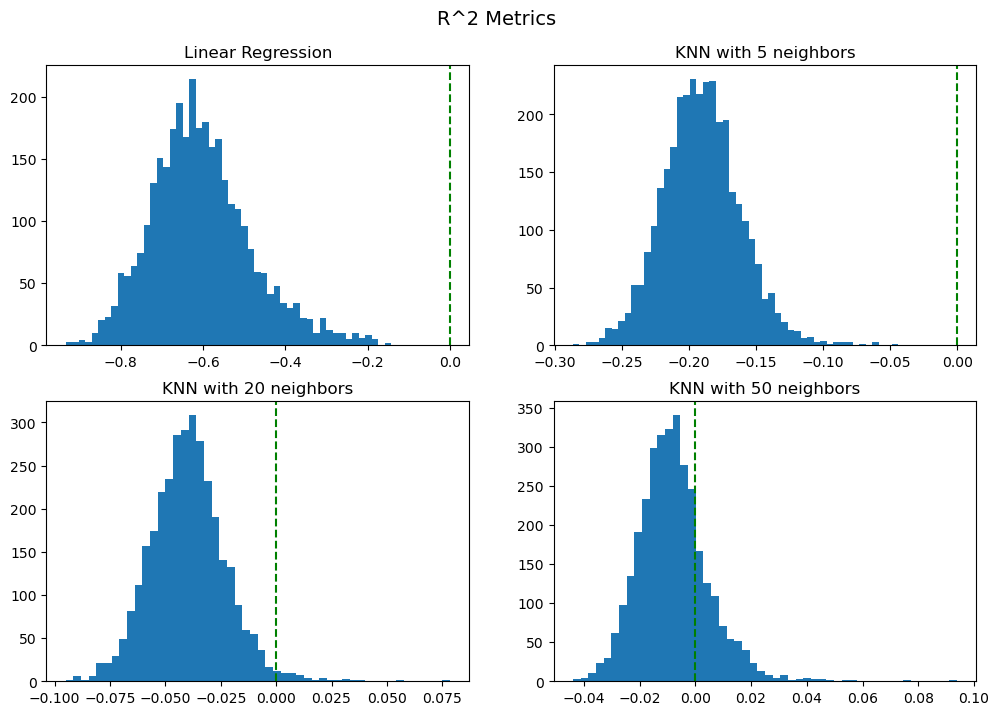

In [35]:
# Display histograms of the predictability maps. 
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
fig.suptitle('R^2 Metrics', fontsize = 14, y = 0.95)

# Linear regression. 
axes[0, 0].hist(predictability_map_lr_pb, bins = 50)
axes[0, 0].axvline(0, 0, 1, linestyle = 'dashed', color = 'green')
axes[0, 0].set_title('Linear Regression')

# KNN with 5 neighbors. 
axes[0, 1].hist(predictability_map_knn5_pb, bins = 50)
axes[0, 1].axvline(0, 0, 1, linestyle = 'dashed', color = 'green')
axes[0, 1].set_title('KNN with 5 neighbors')

# KNN with 20 neighbors. 
axes[1, 0].hist(predictability_map_knn20_pb, bins = 50)
axes[1, 0].axvline(0, 0, 1, linestyle = 'dashed', color = 'green')
axes[1, 0].set_title('KNN with 20 neighbors')

# KNN with 50 neighbors. 
axes[1, 1].hist(predictability_map_knn50_pb, bins = 50)
axes[1, 1].axvline(0, 0, 1, linestyle = 'dashed', color = 'green')
axes[1, 1].set_title('KNN with 50 neighbors');

In [36]:
# Select a model. 
predictability_map = predictability_map_knn20_pb
dict_predictions = dict_predictions_knn20_pb
dict_baseline = dict_baseline_knn20_pb

In [37]:
# Retrieve the voxel with the highest predictability. 
predictability_map.argmax()

1577

In [38]:
# Sort the voxel indexes by ascending R^2 metrics. 
sorted_voxel_indexes = np.argsort(predictability_map)
sorted_voxel_indexes

array([2365, 1368,  351, ..., 1774, 1570, 1577])

In [39]:
# Retrieve the 10 voxels with the highest predictability. 
nb_high_predictability_voxels = 10
high_predictability_voxels = sorted_voxel_indexes[-nb_high_predictability_voxels:]
high_predictability_voxels

array([1585, 1773, 1199, 1568, 1576, 2995, 1584, 1774, 1570, 1577])

In [40]:
# Display the R^2 metrics of these voxels. 
predictability_map[high_predictability_voxels]

array([0.0262407 , 0.02710118, 0.02739814, 0.03047884, 0.03105112,
       0.03115617, 0.03506663, 0.03969419, 0.05586839, 0.07842394])

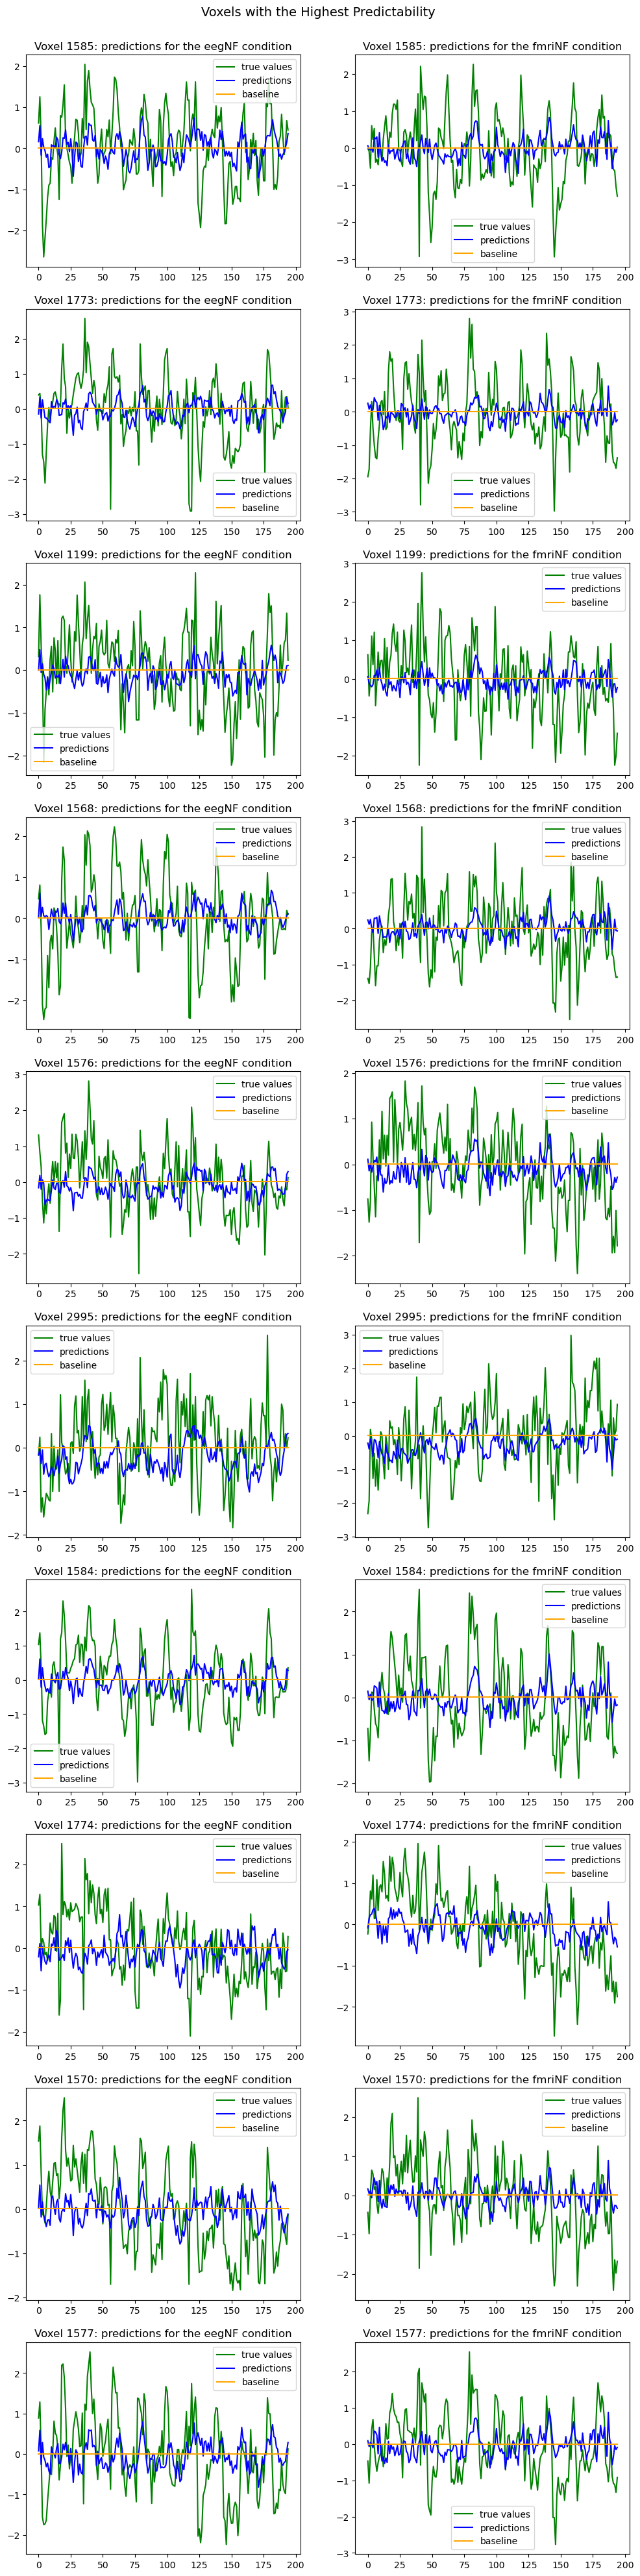

In [41]:
# Plot the true values, the predictions, and the baseline for all the voxels with the highest predictability. 
fig, axes = plt.subplots(nrows = nb_high_predictability_voxels, ncols = 2, figsize = (12, 50))
fig.suptitle('Voxels with the Highest Predictability', fontsize = 14, y = 0.895)
subject = subjects[0]
voxel_index = 0

# Iterate through all target voxels. 
for voxel in high_predictability_voxels:

    # Plot the true values, the predictions, and the baseline for the eegNF condition. 
    axes[voxel_index, 0].plot(dict_targets_values[subject]['eegNF'][selected_sequence_length:, voxel], color = 'green', label = 'true values')
    axes[voxel_index, 0].plot(dict_predictions[subject]['eegNF'][:, voxel], color = 'blue', label = 'predictions')
    axes[voxel_index, 0].plot(dict_baseline[subject][:, voxel], color = 'orange', label = 'baseline')
    axes[voxel_index, 0].legend()
    axes[voxel_index, 0].set_title('Voxel ' + str(voxel) + ': predictions for the eegNF condition')

    # Plot the true values, the predictions, and the baseline for the fmriNF condition. 
    axes[voxel_index, 1].plot(dict_targets_values[subject]['fmriNF'][selected_sequence_length:, voxel], color = 'green', label = 'true values')
    axes[voxel_index, 1].plot(dict_predictions[subject]['fmriNF'][:, voxel], color = 'blue', label = 'predictions')
    axes[voxel_index, 1].plot(dict_baseline[subject][:, voxel], color = 'orange', label = 'baseline')
    axes[voxel_index, 1].legend()
    axes[voxel_index, 1].set_title('Voxel ' + str(voxel) + ': predictions for the fmriNF condition')

    # Increment. 
    voxel_index += 1

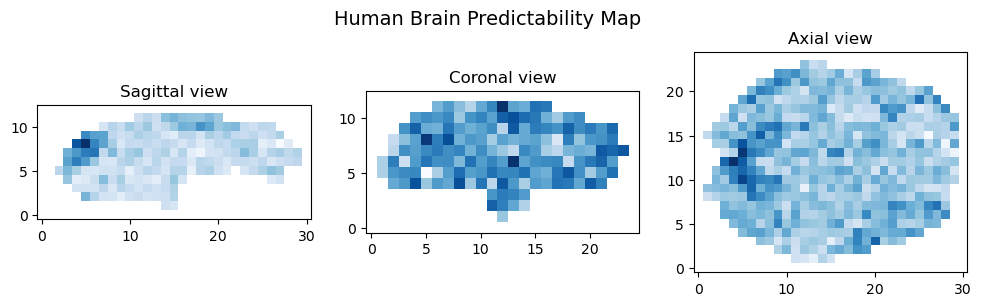

In [42]:
# Retrieve the voxel indexes. 
voxel_indexes = dict_voxel_indexes[subject]['eegfmriNF']

# Reconstruct the brain predictability map, a 3D brain image showing the R^2 metrics for each voxel. 
brain_predictability_map = build_brain_predictability_map(voxel_indexes, predictability_map)

# Display the brain predictability map at the middle section coordinates. 
middle_coord = middle_sections(brain_predictability_map)
display_brain_predictability_map(brain_predictability_map, middle_coord, colormap = 'Blues')